In [1]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

# Set number of threads
tf.config.threading.set_intra_op_parallelism_threads(96)  # Use all logical cores
tf.config.threading.set_inter_op_parallelism_threads(2)   # Experiment with inter-op threads
# Enable XLA JIT compilation
tf.config.optimizer.set_jit(True)

E0000 00:00:1728727033.933956      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D1012 09:57:13.942031867      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1012 09:57:13.942047349      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1012 09:57:13.942050971      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1012 09:57:13.942053557      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1012 09:57:13.942056074      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

In [2]:
#with strategy.scope():
# Load the dataset
data = np.load('/kaggle/input/1024age5/AGE_1024_512_Class5.npz') #/home/showv/BanglaOCR/Dataset
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']

# Reshape the images (from flat to original size)
X_train = X_train.reshape((-1, 512, 1024, 1)) #.astype(np.float16)  # Grayscale
X_test = X_test.reshape((-1, 512, 1024, 1)) #.astype(np.float16)
    
# Convert grayscale to 3 channels by repeating the single channel
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Normalize pixel values (0-255) to range (0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (9154, 512, 1024, 3)
y_train shape: (9154, 5)
X_test shape: (2289, 512, 1024, 3)
y_test shape: (2289, 5)


In [3]:
# # !echo $CUDA_VISIBLE_DEVICES
# # !export CUDA_VISIBLE_DEVICES=0,1

# import tensorflow as tf

# # Check if GPU is available
# print(tf.config.list_physical_devices('GPU'))
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [4]:
import tensorflow as tf

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# Create a strategy for distributed training
#strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1728727166.333606      13 service.cc:145] XLA service 0x580ac4f595a0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728727166.333672      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1728727166.333677      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1728727166.333679      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1728727166.333682      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1728727166.333685      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1728727166.333688      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1728727166.333690      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1728727166.333693      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [5]:
#with strategy.scope():
with tpu_strategy.scope():
    # Define the base model with ImageNet weights, without the top layers
    base_model = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=(512, 1024, 3))
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Add custom layers on top of the base model
    inputs = Input(shape=(512, 1024, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Global average pooling layer
    x = Dense(128, activation='relu')(x)  # Custom dense layer
    outputs = Dense(5, activation='softmax')(x)  # Output layer for 2 classes
    
    # Create the final model
    model = Model(inputs, outputs)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
model.summary()

I0000 00:00:1728727170.981276      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 1024, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-m (Functional)   │ (None, 16, 32, 1280)   │    53,150,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,315,001 (203.38 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 53,150,388 (202.75 MB)

In [6]:
class SaveHistory(Callback):
    def __init__(self, filename):
        super(SaveHistory, self).__init__()
        self.filename = filename

    def on_epoch_end(self, epoch, logs=None):
        # If the file exists, load the previous history
        try:
            with open(self.filename, 'r') as f:
                history = json.load(f)
        except FileNotFoundError:
            history = {}
        
        # Append new logs to the history
        for key, value in logs.items():
            if key not in history:
                history[key] = []
            history[key].append(value)
        
        # Save the updated history to file
        with open(self.filename, 'w') as f:
            json.dump(history, f)


# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#checkpoint = ModelCheckpoint('AP-EfficientNetV2M_1024Age_checkpoint.keras', monitor='val_loss', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
history_callback = SaveHistory('AP-EfficientNetV2M_1024Age_history.json')

In [7]:
# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,  # You can increase epochs based on performance
                    batch_size=64,
                    callbacks=[early_stopping, history_callback])

Epoch 1/100


2024-10-12 10:04:37.342933: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1728727483.297288     741 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(a5cf7b5b308e1b19:0:0), session_name()
I0000 00:00:1728727575.496885     741 tpu_compile_op_common.cc:245] Compilation of a5cf7b5b308e1b19:0:0 with session name  took 1m32.199540487s and succeeded
I0000 00:00:1728727575.768571     741 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(a5cf7b5b308e1b19:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_13557549301457676159", property.function_library_fingerprint = 7199973447052423218, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().

143/144 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.2171 - loss: 1.6126

I0000 00:00:1728727679.411296     740 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(7a91b77337b26268:0:0), session_name()
I0000 00:00:1728727774.219885     740 tpu_compile_op_common.cc:245] Compilation of 7a91b77337b26268:0:0 with session name  took 1m34.808543027s and succeeded
I0000 00:00:1728727774.492162     740 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(7a91b77337b26268:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_13557549301457676159", property.function_library_fingerprint = 7199973447052423218, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,512,1024,3,;2,5,;", property.guaranteed_constants_size = 0, e

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2169 - loss: 1.6127   

2024-10-12 10:10:45.840013: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
I0000 00:00:1728727848.788021     741 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(102db5c58842b1bb:0:0), session_name()
I0000 00:00:1728727859.415212     741 tpu_compile_op_common.cc:245] Compilation of 102db5c58842b1bb:0:0 with session name  took 10.627140395s and succeeded
I0000 00:00:1728727859.456809     741 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(102db5c58842b1bb:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_17403841765230993175", property.function_library_fingerprint = 4465339541917344446, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, 

144/144 ━━━━━━━━━━━━━━━━━━━━ 435s 2s/step - accuracy: 0.2168 - loss: 1.6127 - val_accuracy: 0.2160 - val_loss: 1.6122
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 119s 809ms/step - accuracy: 0.2262 - loss: 1.6070 - val_accuracy: 0.2091 - val_loss: 1.6041
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 118s 798ms/step - accuracy: 0.1959 - loss: 1.6111 - val_accuracy: 0.1882 - val_loss: 1.6191
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 117s 792ms/step - accuracy: 0.2008 - loss: 1.6122 - val_accuracy: 0.1882 - val_loss: 1.6072
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 117s 795ms/step - accuracy: 0.2023 - loss: 1.6102 - val_accuracy: 0.2125 - val_loss: 1.6061
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 117s 795ms/step - accuracy: 0.2019 - loss: 1.6139 - val_accuracy: 0.2369 - val_loss: 1.6063
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 122s 826ms/step - accuracy: 0.1974 - loss: 1.6104 - val_accuracy: 0.2613 - val_loss: 1.5977
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 117s 795ms/step - accuracy: 0.1995 - loss: 

In [8]:
# Load the saved model and history
# from tensorflow.keras.models import load_model

# model = load_model('AP-MobileNetV3L_1024Age_checkpoint.keras')
# with open('AP-MobileNetV3L_1024Age_history.json', 'r') as f:
#     history = json.load(f)

# history = model.fit(X_train, y_train,
#                     validation_data=(X_test, y_test),
#                     epochs=10,  # You can increase epochs based on performance
#                     batch_size=32,
#                     callbacks=[early_stopping, checkpoint, history_callback])

In [13]:
# Save the model in .keras format
#model.save('AP-EfficientNetV2M_Model_1024Age_Trained.keras')

# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

I0000 00:00:1728733218.402044     740 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(60c3a50218370d92:0:0), session_name()


 1/72 ━━━━━━━━━━━━━━━━━━━━ 15:13 13s/step - accuracy: 0.0000e+00 - loss: 1.6639

I0000 00:00:1728733229.986078     740 tpu_compile_op_common.cc:245] Compilation of 60c3a50218370d92:0:0 with session name  took 11.583936234s and succeeded
I0000 00:00:1728733230.025823     740 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(60c3a50218370d92:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_17403841765230993175", property.function_library_fingerprint = 4465339541917344446, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,512,1024,3,;4,5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728733230.025865     740 tpu_compilation_cache_interface.cc:541] After adding entry for key

71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.2116 - loss: 1.6072

I0000 00:00:1728733246.101273     740 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ee86c9e69625bb24:0:0), session_name()


72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 401ms/step - accuracy: 0.2116 - loss: 1.6072


I0000 00:00:1728733258.437128     740 tpu_compile_op_common.cc:245] Compilation of ee86c9e69625bb24:0:0 with session name  took 12.335810634s and succeeded
I0000 00:00:1728733258.469050     740 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ee86c9e69625bb24:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_17403841765230993175", property.function_library_fingerprint = 4465339541917344446, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,1024,3,;3,5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728733258.469100     740 tpu_compilation_cache_interface.cc:541] After adding entry for key

Test accuracy: 20.91%


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow.keras.optimizers as optimizers
import matplotlib.pyplot as plt

# Get the default learning rate for the Adam optimizer
d_learning_rate = optimizers.Adam().get_config()['learning_rate']

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics calculation
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Additional information
print("Number of Epochs:", len(history.history['accuracy']))
print("Size of Image:", X_train.shape[1:])
print("Learning Rate: ",d_learning_rate)

2024-10-12 11:36:03.332722: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/dense_1/Add/ReadVariableOp.
I0000 00:00:1728732964.762263     740 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(707be063ab547f86:0:0), session_name()


 1/72 ━━━━━━━━━━━━━━━━━━━━ 24:46 21s/step

I0000 00:00:1728732976.005212     740 tpu_compile_op_common.cc:245] Compilation of 707be063ab547f86:0:0 with session name  took 11.242866076s and succeeded
I0000 00:00:1728732976.048576     740 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(707be063ab547f86:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_4908535323082661885", property.function_library_fingerprint = 239559513050878882, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728732976.048622     740 tpu_compilation_cache_interface.cc:541] After adding entry for key 707be063ab54

71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step

I0000 00:00:1728733010.772833     740 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(853d756f5896a834:0:0), session_name()
I0000 00:00:1728733027.809974     740 tpu_compile_op_common.cc:245] Compilation of 853d756f5896a834:0:0 with session name  took 17.037103021s and succeeded
I0000 00:00:1728733027.840930     740 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(853d756f5896a834:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_15853756931082360758", property.function_library_fingerprint = 1344991114236562980, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,1024,3,;", property.guaranteed_constants_size = 0, 

72/72 ━━━━━━━━━━━━━━━━━━━━ 73s 732ms/step
Accuracy: 0.23023154215814767
Precision: 0.15023931780205493
Recall: 0.2278585309778594
F1 Score: 0.15411909379402117
Number of Epochs: 41
Size of Image: (512, 1024, 3)
Learning Rate:  0.0010000000474974513


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 380ms/step


<Figure size 1600x1600 with 0 Axes>

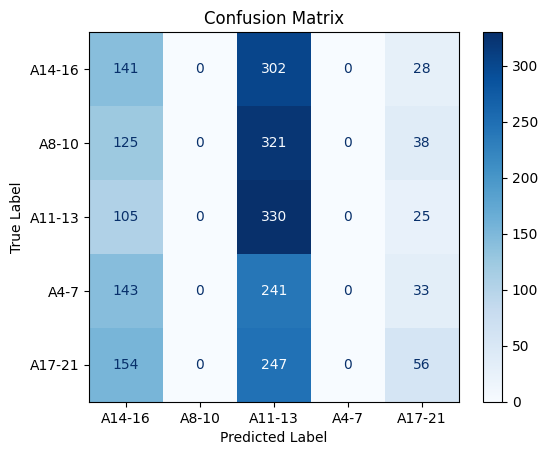

In [11]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model and get predictions
y_pred = model.predict(X_test)

# Convert the predictions from one-hot encoded to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
labels = ['A14-16', 'A8-10', 'A11-13', 'A4-7', 'A17-21']  # Adjust according to your labels

plt.figure(figsize=(16, 16))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

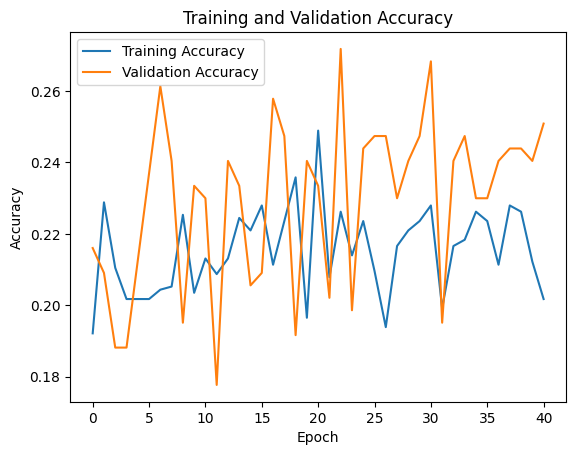

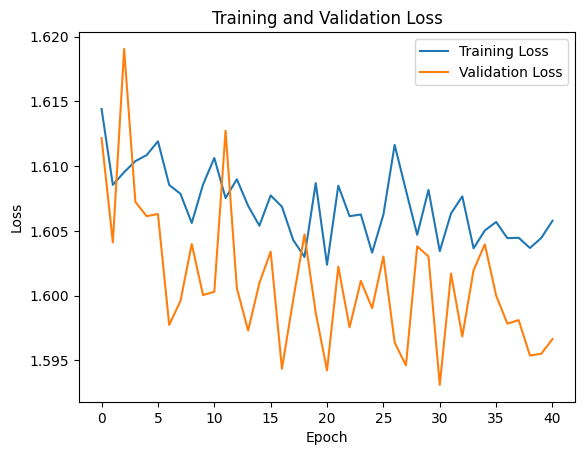

In [12]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()